# Capstone Project - Predicting Car Accident Severity in Seattle
### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem <a name="introduction"></a>

In this project i will try to predict the severity of a car in Seattle crash using a collision dataset. This report will be targeted to stakeholders intreseted in predicting the outcome of a car crash, for example The Seattle Polcie Department.

The severiy of a car crash can split into two groups - Property Damage only and Injury Collission. These are idetfied as 1 and 2 respectevly in the dataset.

i will use my data science knowldge that Ive gained for mthe course and outside matreials to make a Machine Learning model wit haccuracy high enough to be useful for the stakeholders.

## Data

In [20]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')




In [21]:
#Import dataset
df = pd.read_csv("/content/Data-Collisions.csv")

#Set OBJECTID as Index for convienience
df.set_index("OBJECTID");


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Based on my inution the information that is knonwn when an a collison is reported are:

* ADDRTYPE - Collision location: Alley, Block or Intersection
* 
* distance of neighborhood from city center



In [22]:
columns_new = ['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE','PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'HITPARKEDCAR']

df_new = df[columns_new]

In [23]:
df_new.dropna(axis=0, subset=['SEVERITYCODE'], inplace=True)
y = df_new.SEVERITYCODE
df_new.drop(['SEVERITYCODE'], axis=1, inplace=True)

dataTypeSeries = df_new.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries)

Data type of each column of Dataframe :
ADDRTYPE         object
COLLISIONTYPE    object
PERSONCOUNT       int64
VEHCOUNT          int64
JUNCTIONTYPE     object
WEATHER          object
ROADCOND         object
LIGHTCOND        object
HITPARKEDCAR     object
dtype: object


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(df_new, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [27]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()



# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train_full)
X_valid = pd.get_dummies(X_valid_full)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

Best: -0.518595 using {'learning_rate': 0.1, 'n_estimators': 300}
-0.690300 (0.000034) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.687508 (0.000067) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.684772 (0.000099) with: {'learning_rate': 0.0001, 'n_estimators': 300}
-0.682088 (0.000131) with: {'learning_rate': 0.0001, 'n_estimators': 400}
-0.679457 (0.000163) with: {'learning_rate': 0.0001, 'n_estimators': 500}
-0.667031 (0.000314) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.645630 (0.000537) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.628157 (0.000717) with: {'learning_rate': 0.001, 'n_estimators': 300}
-0.613558 (0.000998) with: {'learning_rate': 0.001, 'n_estimators': 400}
-0.601195 (0.001213) with: {'learning_rate': 0.001, 'n_estimators': 500}
-0.601090 (0.001210) with: {'learning_rate': 0.005, 'n_estimators': 100}
-0.563127 (0.001632) with: {'learning_rate': 0.005, 'n_estimators': 200}
-0.546928 (0.001897) with: {'learning_rate': 0.005, '

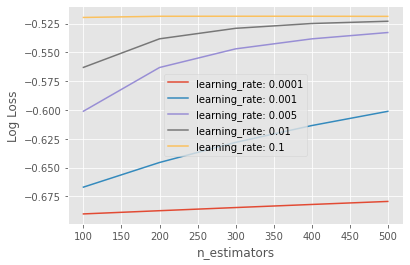

In [12]:

model = XGBClassifier()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.005, 0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')
plt.show()

In [29]:
# Calculate MAE
model2 = XGBClassifier(learning_rate=0.1, n_estimators=300)
model2.fit(X_train, y_train)
predictions_1 = model2.predict(X_train, y_train)
mae_1 = mean_absolute_error(predictions_1, y_train)

print("Mean Absolute Error:" , mae_1)

#sklearn.metrics.r2_score(y_true, y_pred)

ValueError: ignored